# <font color=orange>**Evrisimsel Sinir Aglari ile Nesne Tespiti**</font> <font color=gray>**(CNN)**</font>

## <font color=orange>**ResNet Evrişimsel Sinir Ağları Sınıflandırıcısı ile Nesne Tespiti Kodlama**</font> <font color=gray>**-**</font>

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sliding_window import sliding_window
from image_pyramid import image_pyramid
from non_max_suppression import non_max_suppression  

In [14]:
# İlklendirme Parametreleri

WIDTH = 600
HEIGHT = 600
PYR_SCALE = 1.5  #resim piramidinin scale faktoru
WIN_STEP = 16 #kac piksel atlayacak
ROI_SIZE = (200,150)
INPUT_SIZE = (224,224) # Resnet'te kullanilacak resim boyutudur. Resnet'in egitim boyutlari bu old icin.

In [15]:
print('Resnet Yukleniyor...')
model = ResNet50(weights='imagenet', include_top = True)

Resnet Yukleniyor...


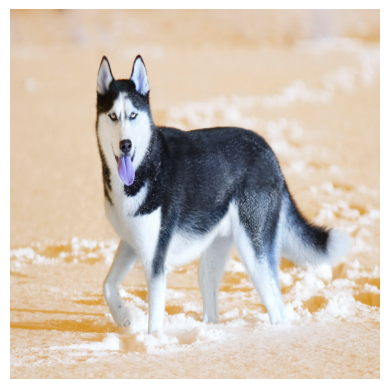

In [16]:
orig = cv2.imread('husky.jpg')
orig = cv2.resize(orig, dsize = (WIDTH, HEIGHT))
plt.imshow(orig),plt.axis('off');

In [17]:
(H,W) = orig.shape[:2]

# image pyramid
pyramid = image_pyramid(orig, PYR_SCALE, ROI_SIZE)

rois = []
locs = []

for image in pyramid:
    
    scale = W/float(image.shape[1])
    
    for (x,y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        
        x = int(x*scale)
        y = int(y*scale)
        w = int(ROI_SIZE[0]*scale)
        h = int(ROI_SIZE[1]*scale)
        
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
    
        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        

rois = np.array(rois, dtype = "float32")

In [18]:
print("sınıflandırma işlemi")
preds = model.predict(rois)

sınıflandırma işlemi
31/31 [==============================] - 69s 2s/step


In [19]:
preds = imagenet_utils.decode_predictions(preds, top = 1)

labels = {}
min_conf = 0.9

for (i,p) in enumerate(preds):
    
    (_, label, prob) = p[0]
    
    if prob >= min_conf:
        
        box = locs[i]
        
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [21]:
for label in labels.keys():
    clone = orig.copy()
    
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY),(endX,endY), (0,255,0), 2)
        
    cv2.imshow('Ilk', clone)
    #Yukaridaki haliyle iki tane obge algilamakta 
    #duzeltme
    clone = orig.copy()
    
    #Non maxima
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    
    boxes = non_max_suppression(boxes, proba)
    
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(clone, (startX, startY),(endX,endY), (0,255,0), 2)
        y = startY-10 if startY-10 > 10 else startY + 10
        cv2.putText(clone,label,(startX,startY),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,255,0), 2)
      
    cv2.imshow('Maxima', clone)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): break